In [1]:
import wfdb
import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import pywt
from statsmodels.robust import mad
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
VALID_CLASSES = np.array(('N','A','V','R','L','a','!','F','f','j','J','/','E','x','e'))

In [3]:
def get_signal_data(path):
    path = os.path.splitext(path)[0]
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path,'atr')
    symbol = np.array(annotation.symbol)
    mask = np.isin(symbol, VALID_CLASSES)
    return record.p_signal[:, 0], symbol[mask], annotation.sample[mask]

In [4]:
def plot_signal(name, start=0, end=None, save_fig=False):
    end = end or len(signal)
    path_name = name
    if 'mitdb' not in path_name:
        path_name = 'mitdb/' + path_name
    signal, _, _ = get_signal_data(path_name)
    plt.plot(signal[start:end])
    plt.show()
    if save_fig:
        plt.savefig(f'plots/{name}_{start}_{end}.png')

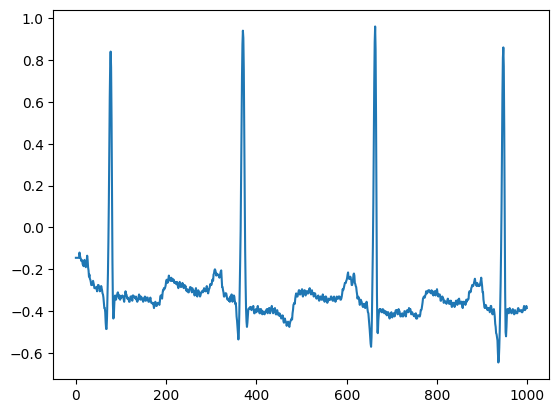

<Figure size 640x480 with 0 Axes>

In [5]:
plot_signal('100', 0, 1000, save_fig=True)

In [6]:
def apply_wavelet(signal, levels=8):
    w=pywt.Wavelet('sym7')
    ca=[]
    cd=[]
    l = signal
    for _ in range(levels):
        (l, h)=pywt.dwt(l, w)
        ca.append(l)
        cd.append(h)

    # FIXME EWW
    l = [0]*len(l)
    l=np.array(l)
    cd.append(l)
    
    tho = mad(cd[0])
    uthr = tho*np.sqrt(2*np.log(len(signal)))
    
    new_cd = []
    for h in cd :
        new_cd.append(pywt.threshold(h, value=uthr, mode='hard'))

    new_cd.reverse()
    return pywt.waverec(new_cd, w)

In [7]:
def get_instances(signal, symbol, position):
    X, y = [], []
    for p, s in zip(position, symbol):
        x = signal[p-90:p+166]
        if len(x) != 256:
            continue
        X.append(x)
        y.append(s)
    return X, y

In [8]:
def one_hot_encode_y(y):
    d = pd.get_dummies(y)
    return d.values, d.columns

In [9]:
def split_data(X, y, **kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=kwargs.get('random_state', 42))
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=kwargs.get('random_state', 42))
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [10]:
def get_training_data():
    paths_data = glob.glob('mitdb/*atr')
    X, y = [], []
    for p in paths_data:
        signal, symbol, position = get_signal_data(p)
        signal = apply_wavelet(signal)
        _X, _y = get_instances(signal, symbol, position)
        X.extend(_X)
        y.extend(_y)
    y, names = one_hot_encode_y(y)
    return split_data(np.array(X), np.array(y)), names

In [11]:
(X_train, X_valid, X_test, y_train, y_valid, y_test), names = get_training_data()

In [12]:
X_train.shape, y_train.shape

((84212, 256), (84212, 15))

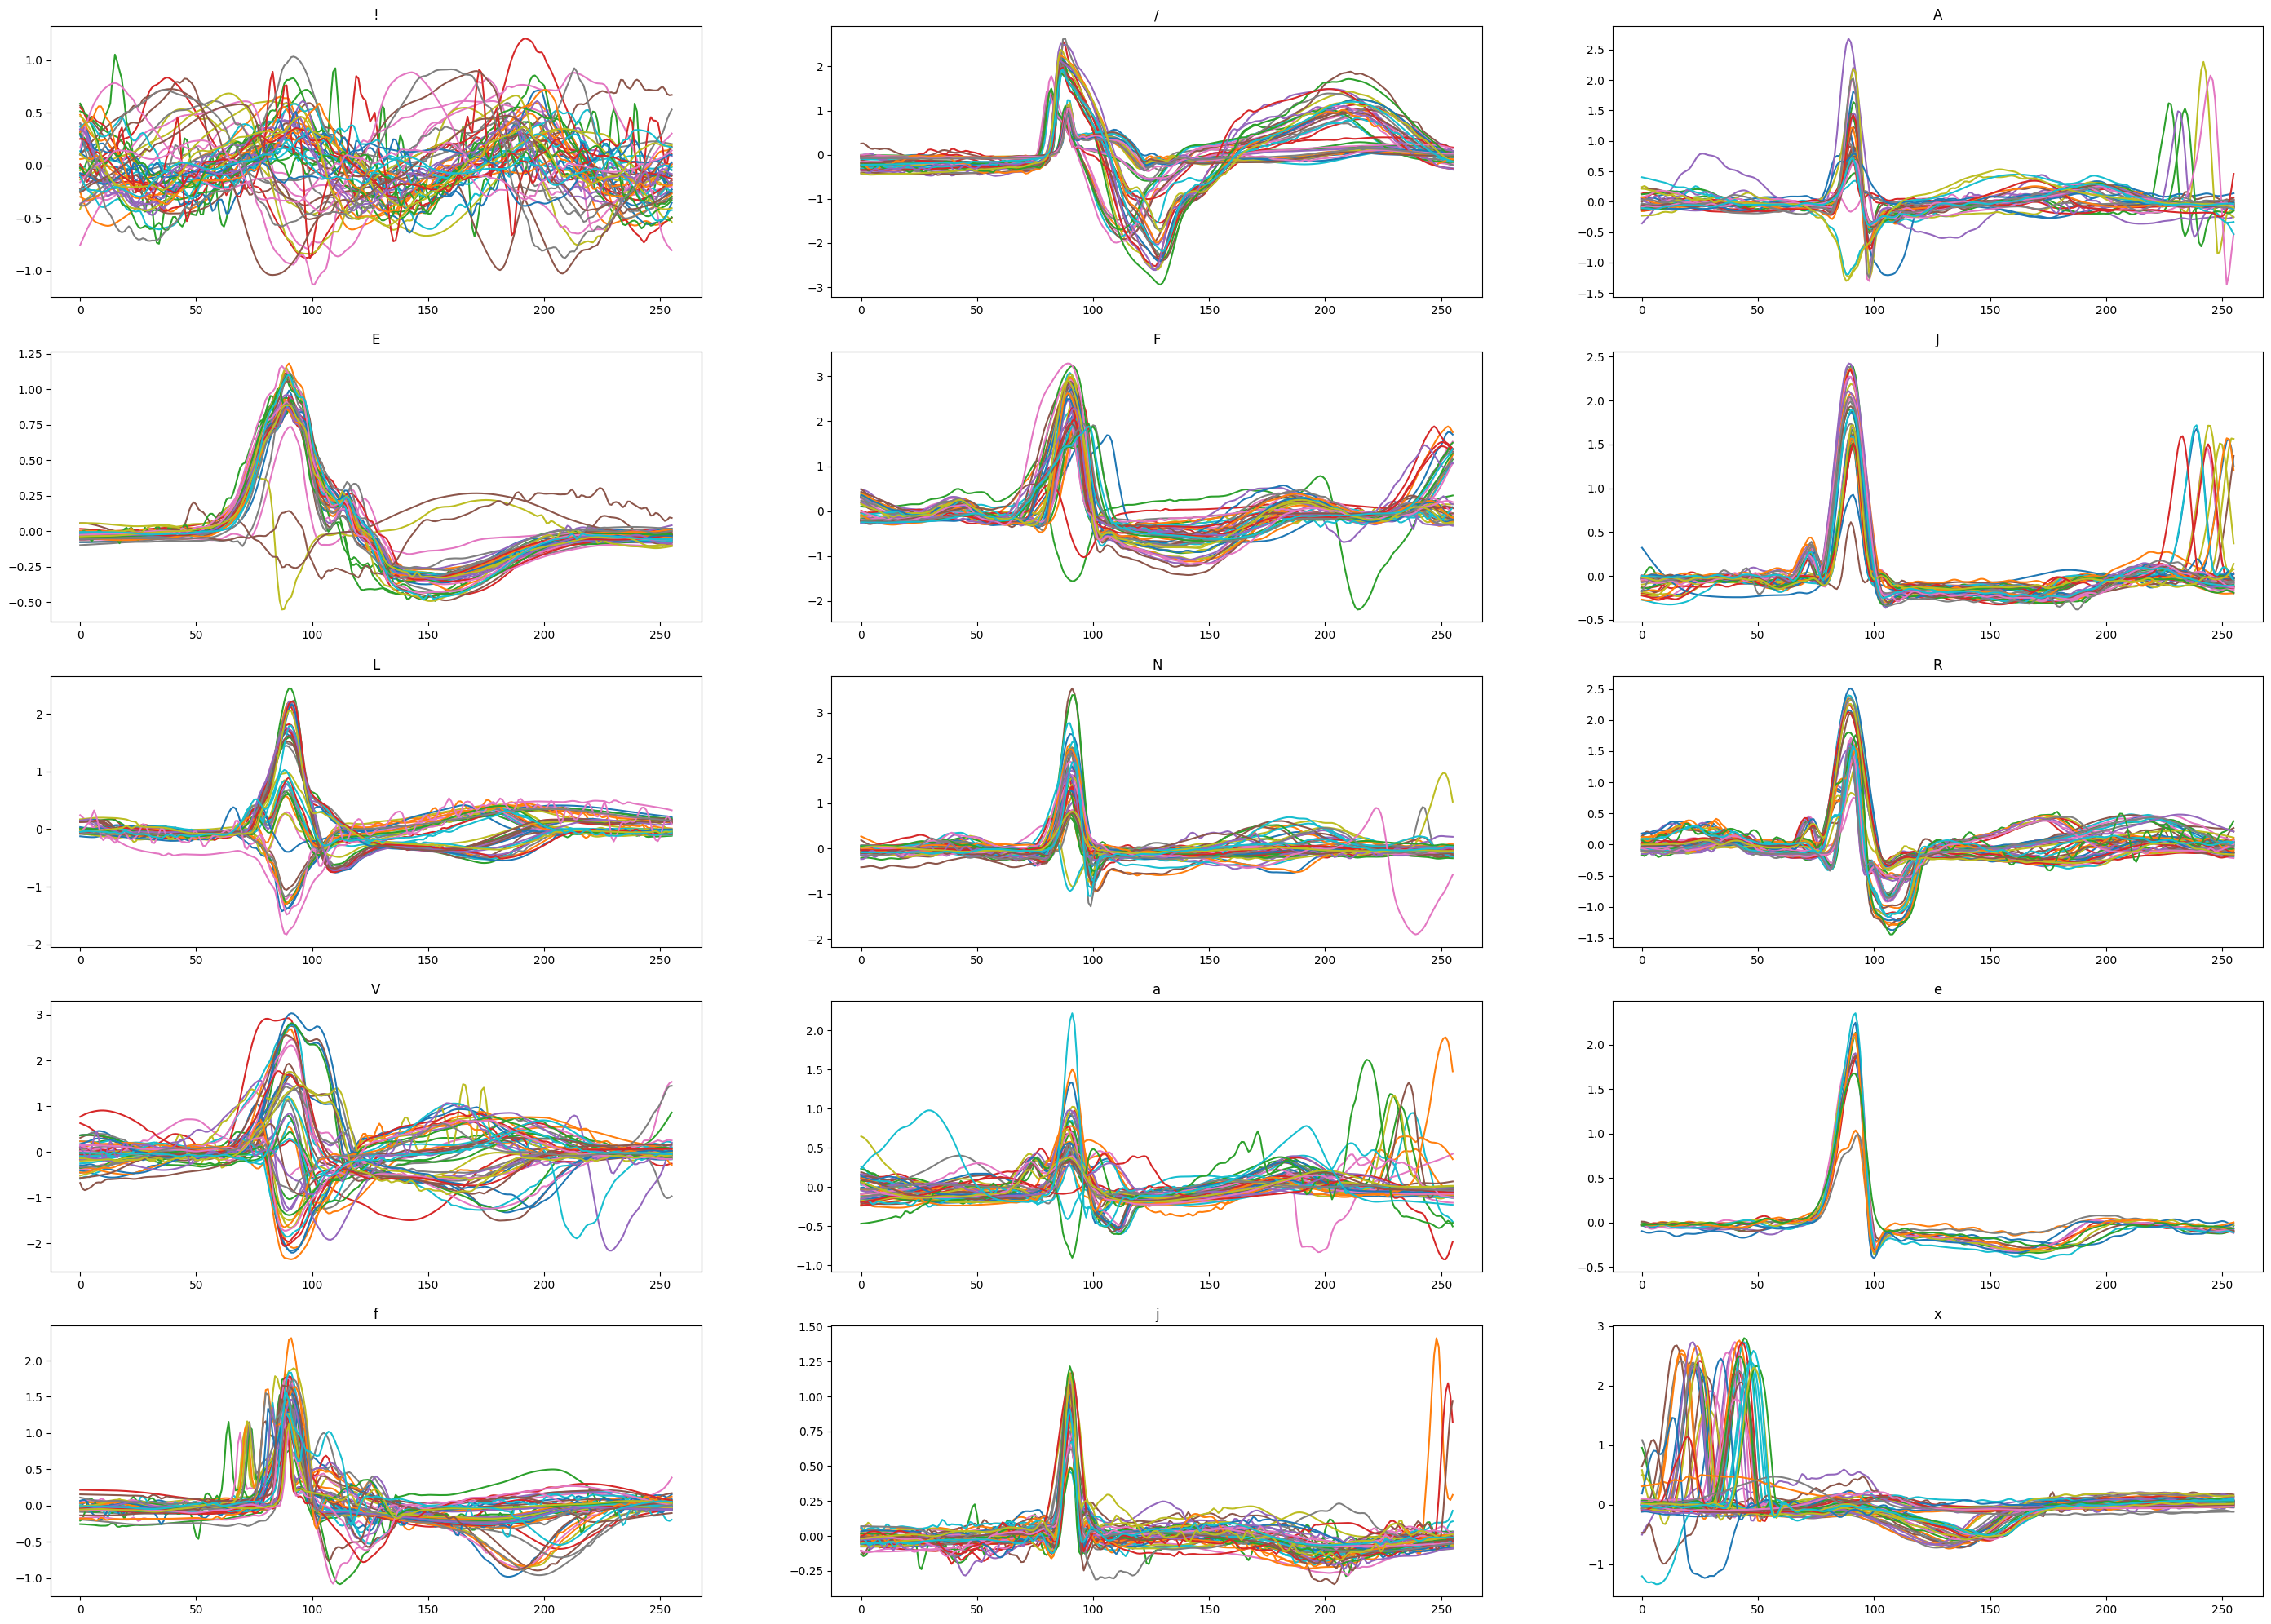

In [38]:
np.random.seed(42)
_, axs = plt.subplots(len(names) // 3, 3, figsize=(35, 25))
axs = axs.flatten()
for i, n in enumerate(names):
    mask = np.argmax(y_train, axis=1) == i
    for j in np.random.permutation(mask.sum())[:50]:
        axs[i].plot(X_train[mask][j])
    axs[i].set_title(n)
plt.show()

In [13]:
def get_model(input_shape=(256,1), num_classes=15):
    inp = tf.keras.layers.Input(shape=input_shape)
    x = inp
    for rate in (1, 2, 4, 8, 16, 32, 64):
        x = tf.keras.layers.Conv1D(32, 2, dilation_rate=rate, activation='relu')(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=inp, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
model = get_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 255, 32)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 253, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 249, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 241, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 225, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 193, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 129, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,855 (218.18 KB)

 Trainable params: 55,855 (218.18 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
if not os.path.exists('model.keras'):
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[es])
    model.save('model.keras')
else:
    model = tf.keras.models.load_model('model.keras')

In [19]:
model.evaluate(X_test, y_test)

517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9849 - loss: 0.0553


[0.05706635117530823, 0.9846181869506836]

In [20]:
pred = np.argmax(model.predict(X_test), axis=1)

517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


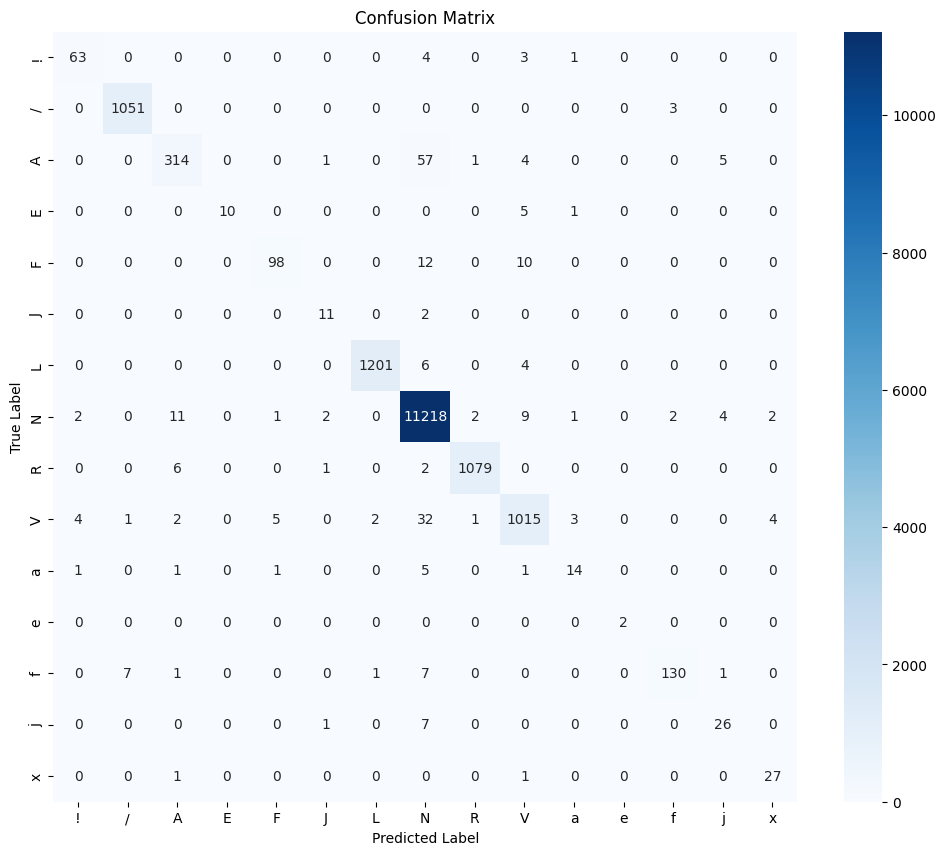

In [21]:
cm = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=names, yticklabels=names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

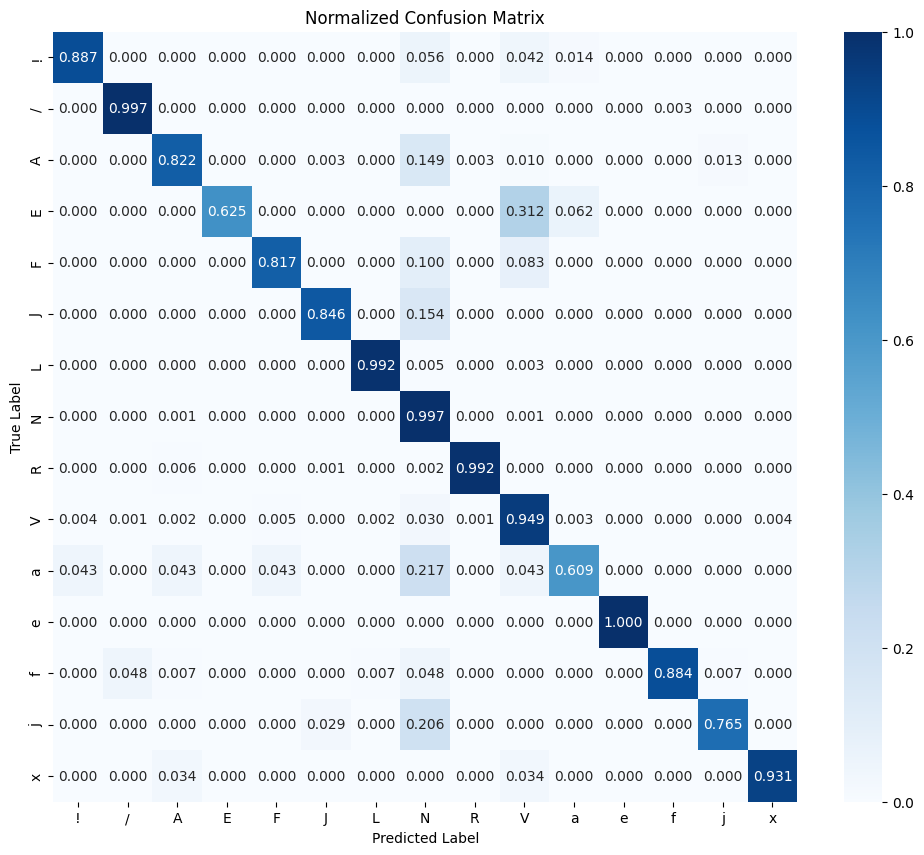

In [22]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', cbar=True, xticklabels=names, yticklabels=names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [43]:
mask = y_test != pred

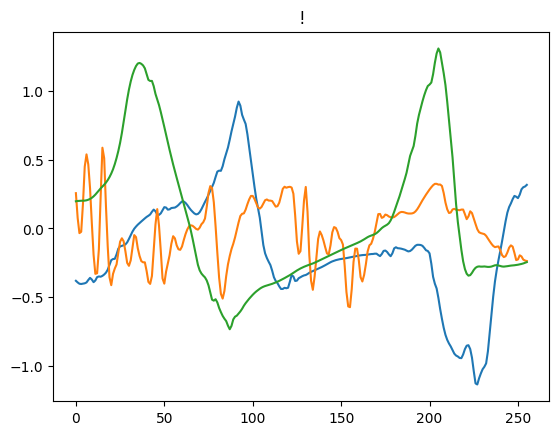

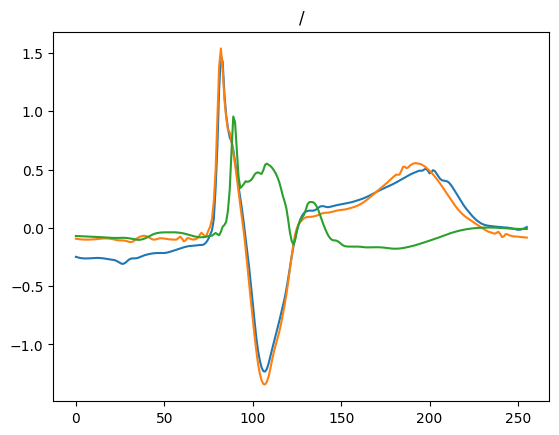

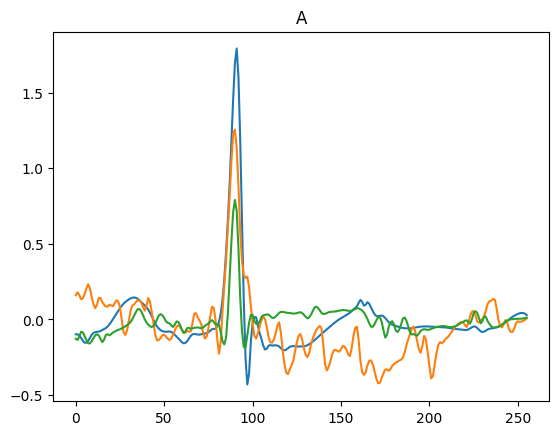

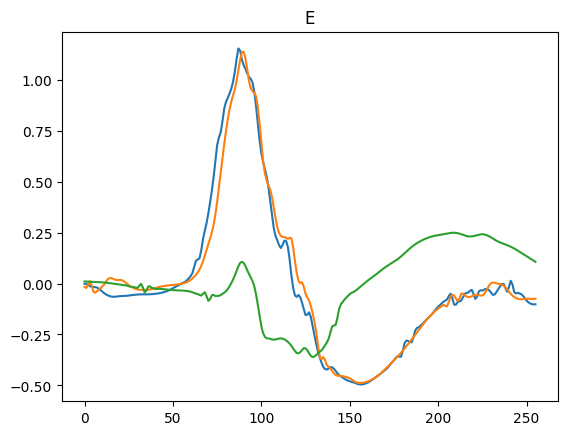

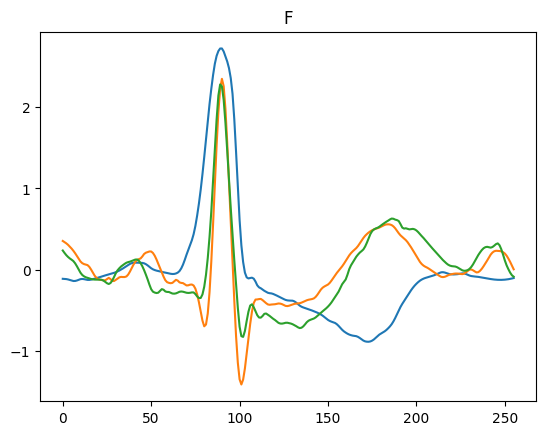

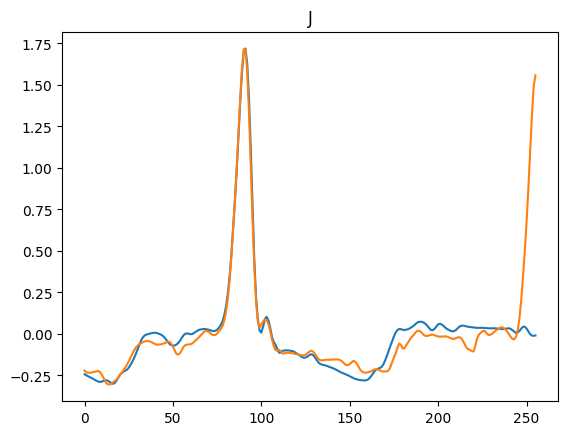

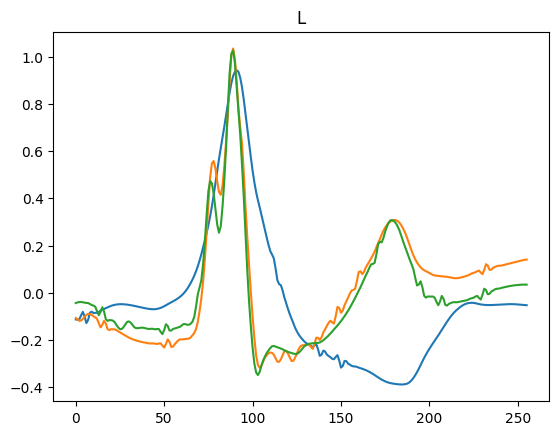

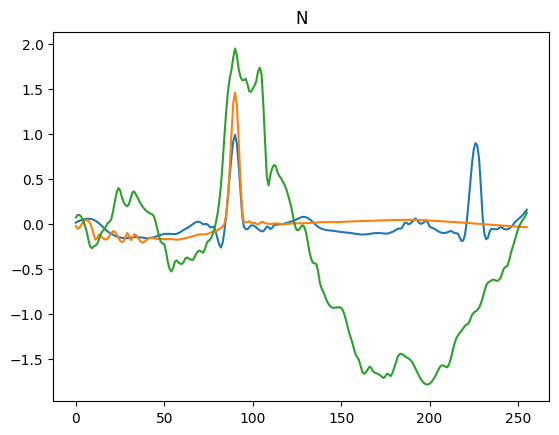

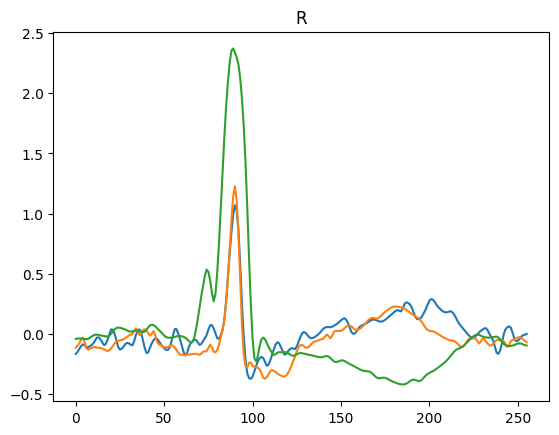

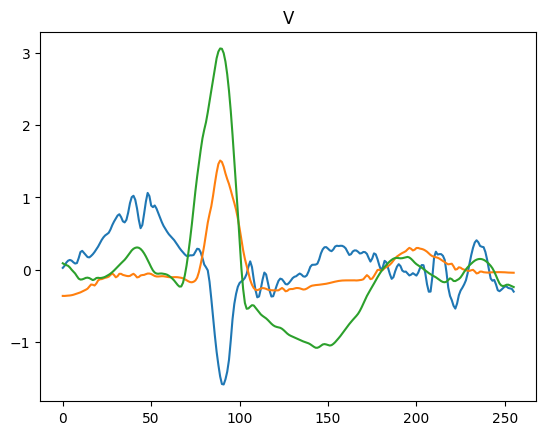

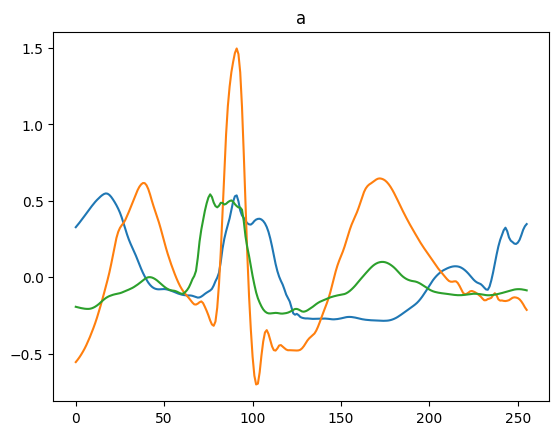

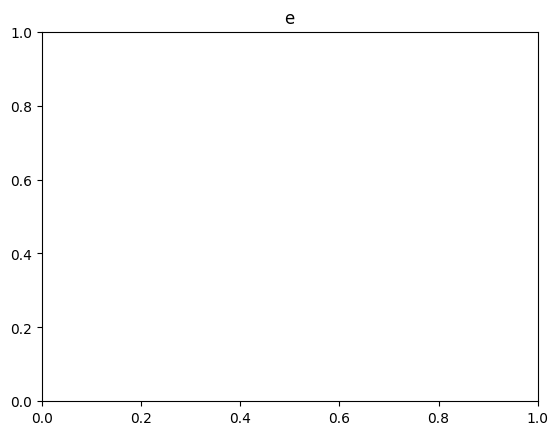

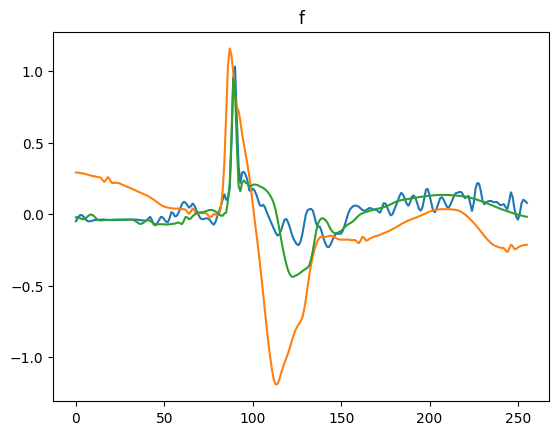

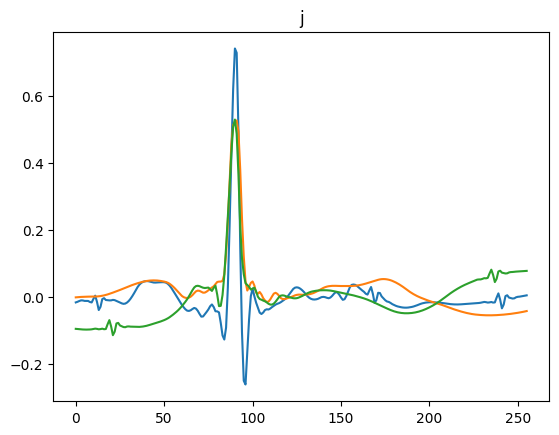

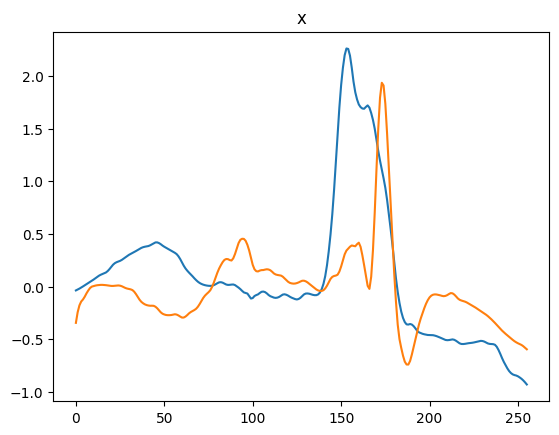

In [ ]:
np.random.seed(42)
for i, n in enumerate(names):
    _, axs = plt.subplots(1, 5, figsize=(15, 15))
    m = (y_test == i) & mask
    for j in np.random.permutation(m.sum())[:5]:
        axs[j].plot(X_test[m][j])
    plt.show()
